# Task 3 Adam Optimizer - Ashish Tara Shivakumar Ireddy - J41325c

In [15]:
# Import required libraries.
import pandas as pd
import numpy as np

from scipy import optimize
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.animation import FuncAnimation

from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

In [3]:
# mountiong the drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [13]:
# Importing the data from the drive
df=pd.read_csv("/content/drive/My Drive/Colab Notebooks/bioresponse.csv")
df

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,...,D1737,D1738,D1739,D1740,D1741,D1742,D1743,D1744,D1745,D1746,D1747,D1748,D1749,D1750,D1751,D1752,D1753,D1754,D1755,D1756,D1757,D1758,D1759,D1760,D1761,D1762,D1763,D1764,D1765,D1766,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,0.243144,0.187856,0.0000,0.000000,0.069000,0.362012,0.301773,0.597930,0.190813,0.107219,0.070500,0.00717,0.137931,1,0.00,0.496683,0.753131,1,1,0.000000,0.262919,0.077200,0.082700,0.200590,0.00000,0.000000,0.000000,0.00,0.162383,0.150153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,0.106480,0.101382,0.1875,0.193548,0.131001,0.350206,0.187419,0.762669,0.180473,0.329962,0.107681,0.01950,0.206897,0,0.75,0.449869,0.720484,0,0,0.666667,0.099400,0.289240,0.216710,0.100295,0.16958,0.235294,0.000000,0.00,0.119104,0.075100,...,0,1,1,0,0,0,1,1,0,1,0,0,1,0,1,1,1,0,0,0,1,0,0,0,1,0,1,1,0,0,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,0.352308,0.193548,0.1250,0.000000,0.068900,0.574628,0.283327,0.510633,0.184480,0.073300,0.061600,0.00566,0.000000,1,0.00,0.486610,0.803577,0,1,0.000000,0.428659,0.032400,0.072400,0.000000,0.03930,0.000000,0.000000,0.00,0.076100,0.225229,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,0.208989,0.000000,0.0000,0.000000,0.145947,0.584688,0.325247,0.496745,0.242288,0.087700,0.075300,0.01680,0.000000,1,0.00,0.459122,0.829482,0,1,0.000000,0.435410,0.118562,0.000000,0.000000,0.00000,0.000000,0.000000,0.00,0.068900,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,0.125177,0.532258,0.0000,0.000000,0.094900,0.540323,0.116775,0.552982,0.167897,0.116140,0.054200,0.01350,0.103448,1,0.00,0.381883,0.913374,0,1,0.000000,0.305333,0.054100,0.170822,0.000000,0.00000,0.176471,0.000000,0.00,0.019900,0.057400,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3746,1,0.033300,0.506409,0.10,0.0,0.209887,0.633426,0.297659,0.376124,0.727093,0.308163,0.000000,0.0000,0.000000,0.071800,0.362006,0.229374,0.603893,0.129706,0.092400,0.036100,0.00473,0.069000,1,0.00,0.486439,0.783710,1,1,0.000000,0.364694,0.136861,0.047300,0.100295,0.00000,0.000000,0.000000,0.00,0.223324,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3747,1,0.133333,0.651023,0.15,0.0,0.151154,0.766505,0.170876,0.404546,0.787935,0.192527,0.085200,0.2500,0.064500,0.121309,0.347521,0.250846,0.660747,0.221975,0.167944,0.065700,0.00939,0.172414,1,0.00,0.390864,0.815279,0,1,0.000000,0.153533,0.127563,0.122141,0.104815,0.08000,0.191429,0.146735,0.00,0.101137,0.075100,...,1,1,0,1,1,1,1,0,1,0,0,1,0,0,0,0,1,1,1,0,1,0,0,0,1,1,1,1,1,0,0,0,1,0,1,0,1,0,0,0
3748,0,0.200000,0.520564,0.00,0.0,0.179949,0.768785,0.177341,0.471179,0.872241,0.122132,0.624027,0.1875,0.064500,0.091700,0.519094,0.243037,0.691896,0.215831,0.338637,0.290643,0.04450,0.103448,1,0.00,0.590995,0.581372,0,0,0.333333,0.128839,0.357203,0.077600,0.028500,0.06200,0.308468,0.166667,0.00,0.019900,0.377263,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3749,1,0.100000,0.765646,0.00,0.0,0.536954,0.634936,0.342713,0.447162,0.672689,0.37293

In [14]:

X=df.iloc[:, 1:]
Y=df[['Activity']]
Y.value_counts(normalize=True)

Activity
1           0.542255
0           0.457745
dtype: float64

In [16]:
X_train, X_test, Y_train, Y_test= train_test_split(X,Y, test_size=0.25 , random_state=0 )

In [17]:
# sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1./(1.+np.exp(-z))
    
    return s


In [18]:
# initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros((dim,1))
    b = np.ones(1)
    
    return w, b

In [19]:
# propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size which equals the number of features
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    m = X.shape[1]
    #print('number of objects = ',len(X))
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b[0] )                                 # compute activation
    cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,(A-Y).T)
    db = (1./m)*np.sum(A-Y,axis=1)

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [26]:
# predict

def predict(w, b, X):
   
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities 
    A = sigmoid(np.dot(w.T,X)+b[0])
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0,i]<=0.5):
            Y_prediction[0][i]=0
        else:
            Y_prediction[0][i]=1
    
    return Y_prediction

In [36]:
def AdamOptimizer(w, b, X, Y, num_iterations, alpha, print_cost = False):
    
    beta_1=0.9
    beta_2=0.999

    costs = []

    eps=1e-8

    m_w=np.zeros(w.shape)
    v_w=np.zeros(w.shape)

    m_b=np.zeros(b.shape)
    v_b=np.zeros(b.shape)

    grads, cost = propagate(w,b,X,Y)
    costs.append(cost)
    
    for i in range(1,num_iterations):       

        grads, cost = propagate(w,b,X,Y)
        dw = grads["dw"]
        db = grads["db"]

        m_w = beta_1 * m_w + (1.0 - beta_1) * dw
        v_w = beta_2 * v_w + (1.0 - beta_2) * dw**2
        mhat_w = m_w / (1.0 - beta_1**(i))
        vhat_w =  v_w / (1.0 - beta_2**(i))

        m_b = beta_1 * m_b + (1.0 - beta_1) * db
        v_b = beta_2 * v_b + (1.0 - beta_2) * db**2
        mhat_b = m_b / (1.0 - beta_1**(i))
        vhat_b = v_b / (1.0 - beta_2**(i))
        
        w=np.subtract(w , alpha*np.divide(mhat_w , (np.sqrt(vhat_w) + eps)))
        b=np.subtract(b , alpha*np.divide(mhat_b , (np.sqrt(vhat_b) + eps)))
        
        costs.append(cost)
                  
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [37]:
def model(X_train, Y_train, X_test, Y_test, optimize, num_iterations, learning_rate , print_cost = False):
    
    np.random.seed(0)
    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    accuracy_train=(100 - np.mean((np.abs(Y_prediction_train - Y_train)).values) * 100)
    accuracy_test=(100 - np.mean((np.abs(Y_prediction_test - Y_test)).values) * 100)
    accuracy={'train': accuracy_train, 'test':accuracy_test }

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return accuracy, parameters, grads, costs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


Accuracy of 0.1 :  {'train': 87.59331674369001, 'test': 75.69296375266525}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


Accuracy of 0.5 :  {'train': 90.15286171347316, 'test': 74.09381663113007}
Accuracy of 0.01 :  {'train': 84.57163170991824, 'test': 76.11940298507463}
Accuracy of 0.05 :  {'train': 86.0646996089584, 'test': 75.79957356076758}
Accuracy of 0.001 :  {'train': 77.46178457163171, 'test': 70.1492537313433}


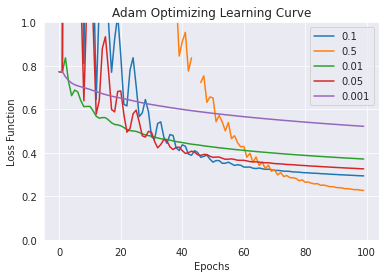

In [41]:
accuracy_adam=[] #to store Accuracy of corresponding Learning rate
cost_adam=[]

num_iterations = 100

np.random.seed(0)

dim = 1

w, b = initialize_with_zeros(dim)

accuracy, params, grads, costs = model(X_train.T, Y_train.T, X_test.T, Y_test.T, AdamOptimizer, num_iterations , 0.1, print_cost = False)

cost_adam.append(costs)
  
accuracy_adam.append(accuracy)

print("Accuracy of 0.1 : ", accuracy)

plt.plot(np.arange(len(costs)), costs, label= "0.1")

#----------------------------------------------------------------
w, b = initialize_with_zeros(dim)

accuracy, params, grads, costs = model(X_train.T, Y_train.T, X_test.T, Y_test.T, AdamOptimizer, num_iterations , 0.5, print_cost = False)

cost_adam.append(costs)
  
accuracy_adam.append(accuracy)

print("Accuracy of 0.5 : ", accuracy)

plt.plot(np.arange(len(costs)), costs, label= "0.5")
#----------------------------------------------------------------

w, b = initialize_with_zeros(dim)

accuracy, params, grads, costs = model(X_train.T, Y_train.T, X_test.T, Y_test.T, AdamOptimizer, num_iterations , 0.01, print_cost = False)

cost_adam.append(costs)
  
accuracy_adam.append(accuracy)

print("Accuracy of 0.01 : ", accuracy)

plt.plot(np.arange(len(costs)), costs, label= "0.01")

#----------------------------------------------------------------

w, b = initialize_with_zeros(dim)

accuracy, params, grads, costs = model(X_train.T, Y_train.T, X_test.T, Y_test.T, AdamOptimizer, num_iterations , 0.05, print_cost = False)

cost_adam.append(costs)
  
accuracy_adam.append(accuracy)

print("Accuracy of 0.05 : ", accuracy)

plt.plot(np.arange(len(costs)), costs, label= "0.05")
#----------------------------------------------------------------

w, b = initialize_with_zeros(dim)

accuracy, params, grads, costs = model(X_train.T, Y_train.T, X_test.T, Y_test.T, AdamOptimizer, num_iterations , 0.001, print_cost = False)

cost_adam.append(costs)
  
accuracy_adam.append(accuracy)

print("Accuracy of 0.001 : ", accuracy)

plt.plot(np.arange(len(costs)), costs, label= "0.001")
#----------------------------------------------------------------

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss Function")
plt.title("Adam Optimizing Learning Curve")
plt.ylim(0, 1)
plt.show()